In [1]:
library(transformeR)
library(loadeR)
library(loadeR.2nc)
library(geoprocessoR)
library(visualizeR)
library(RColorBrewer)
library(sp)
library(rgdal)


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.1.3 (2021-08-04) is loaded



Get the latest stable version (2.2.2) using <devtools::install_github('SantanderMetGroup/transformeR')>



Please see 'citation("transformeR")' to cite this package.



Loading required package: rJava



Loading required package: loadeR.java



Java version 11x amd64 by Oracle Corporation detected



NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready



Loading required package: climate4R.UDG



climate4R.UDG version 0.2.3 (2021-07-05) is loaded



Get the latest stable version (0.2.4) using <devtools::install_github('SantanderMetGroup/climate4R.UDG')>



Please use 'citation("climate4R.UDG")' to cite this package.



loadeR version 1.7.1 (2021-07-05) is loaded



Get the latest stable version (1.8.1) using <devtools::install_github(c('SantanderMetGroup/climate4R.UDG','SantanderMetGroup/loadeR'))>



Please use 'citation("loadeR")' to cite this package.



geoprocessoR version 0.2.0 (2020-01-06) is loaded



Get the latest stable version (0.2.2) using <devtools::install_github('SantanderMetGroup/geoprocessoR')>



Please see 'citation("geoprocessoR")' to cite this package.



visualizeR version 1.6.1 (2021-03-11) is loaded



Get the latest stable version (1.6.4) using <devtools::install_github('SantanderMetGroup/visualizeR')>



Please see 'citation("visualizeR")' to cite this package.



rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.2.1, released 2020/12/29
Path to GDAL shared files: /DATA/miniconda3/envs/atlas-jupyterbook/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.2.0, November 1st, 2020, [PJ_VERSION: 720]
Path to PROJ shared files: /DATA/miniconda3/envs/atlas-jupyterbook/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.



In [2]:
map <- readGDAL("auxiliary-material/CMIP5 - Mean temperature (T) Change deg C - Long Term (2081-2100) RCP 8.5 1986-2005 - Annual (mean of 29 models).tiff")

auxiliary-material/CMIP5 - Mean temperature (T) Change deg C - Long Term (2081-2100) RCP 8.5 1986-2005 - Annual (mean of 29 models).tiff has GDAL driver GTiff 
and has 90 rows and 180 columns


In [3]:
delta <- sgdf2clim(map)

NOTE: One single grid passed to the function: nothing to bind, so the original grid was returned



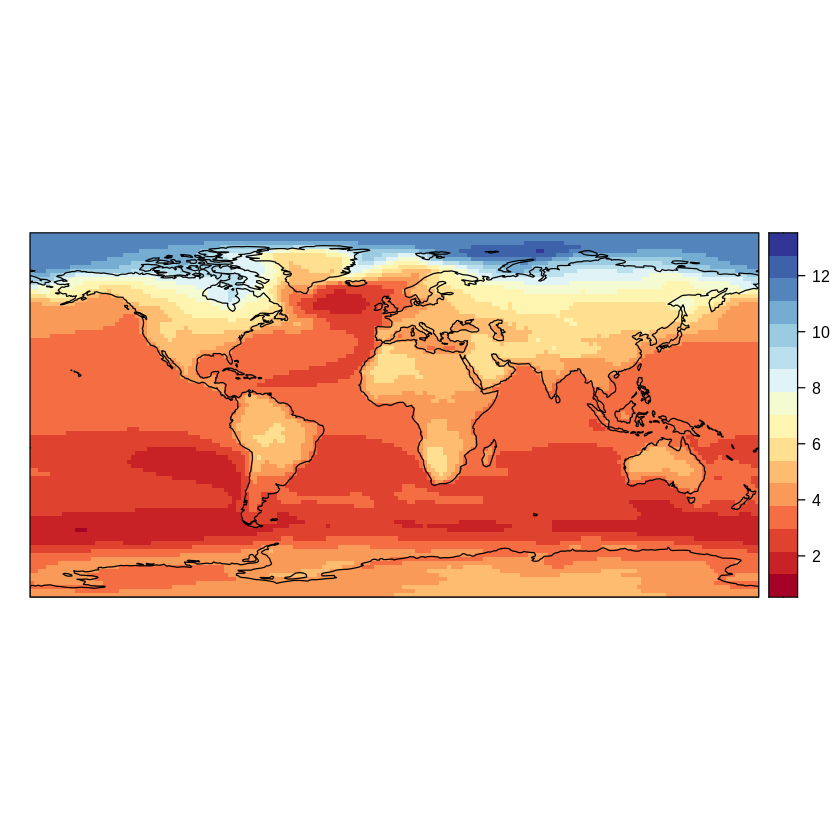

In [4]:
spatialPlot(delta, backdrop.theme = "coastline")

In [5]:
mask <- loadGridData("../reference-grids/land_sea_mask_2degree.nc4", var = "sftlf")
mask.land <- binaryGrid(mask, condition = "GT", threshold = 0.999, values = c(NA, 1))

[2024-04-17 11:25:31] Defining geo-location parameters



[2024-04-17 11:25:31] Defining time selection parameters



NOTE: Undefined Dataset Time Axis (static variable)



[2024-04-17 11:25:31] Retrieving data subset ...



[2024-04-17 11:25:31] Done



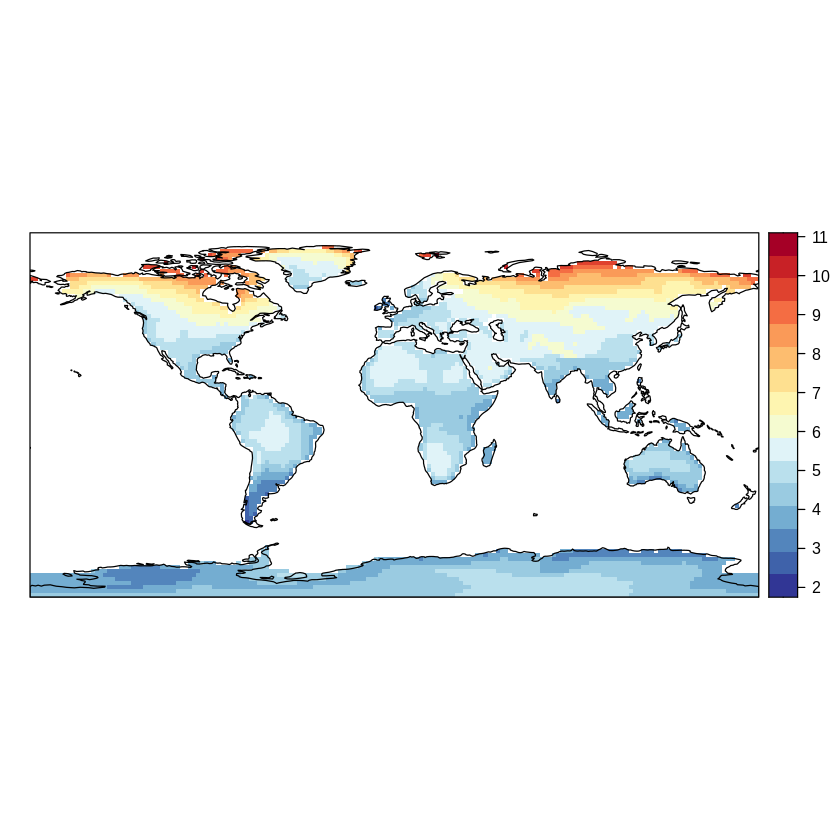

In [6]:
delta.masked <- gridArithmetics(delta, mask.land, operator = "*")
spatialPlot(delta.masked, backdrop.theme = "coastline", rev.colors = TRUE)

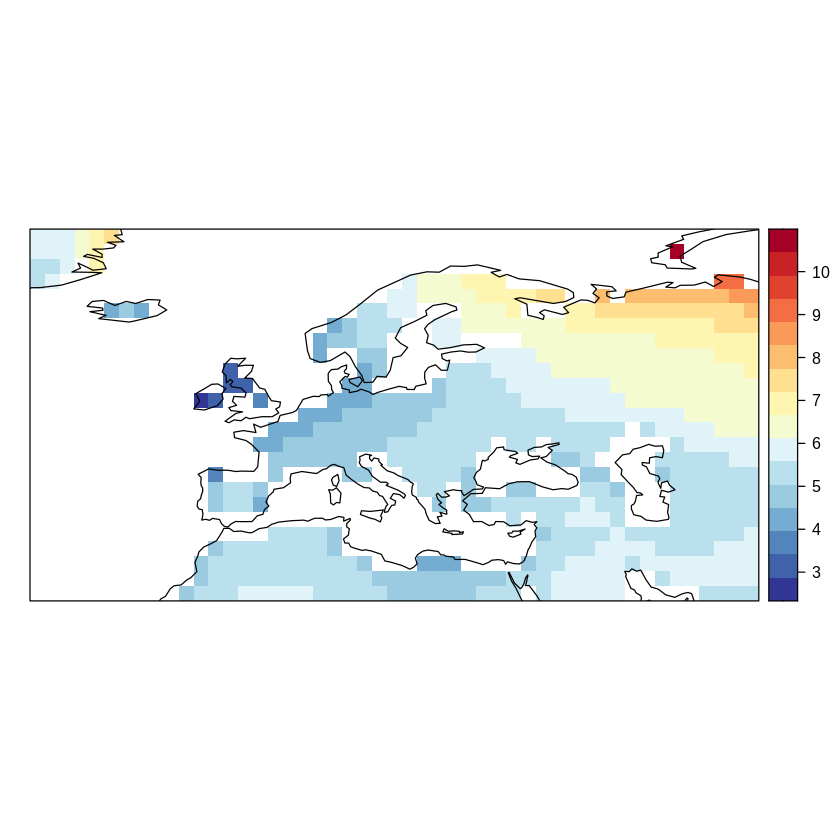

In [7]:
delta.EU <- subsetGrid(delta.masked, lonLim = c(-30, 65), latLim = c(28, 75))
spatialPlot(delta.EU, backdrop.theme = "coastline", rev.colors = TRUE)

In [8]:
regions <- get(load("../reference-regions/IPCC-WGI-reference-regions-v4_R.rda"))
regions <- as(regions, "SpatialPolygons")
proj4string(regions) <- CRS("+init=epsg:4326")

Warning message in proj4string(obj):
“CRS object has comment, which is lost in output”


Warning message in `proj4string<-`(`*tmp*`, value = new("CRS", projargs = "+proj=longlat +datum=WGS84 +no_defs")):
“A new CRS was assigned to an object with an existing CRS:
+proj=longlat +ellps=WGS84 +no_defs
without reprojecting.
For reprojection, use function spTransform”


In [9]:
delta.masked <- projectGrid(delta.masked, proj4string(regions))

Warning message in proj4string(regions):
“CRS object has comment, which is lost in output”


Warning message in projectGrid(delta.masked, proj4string(regions)):
“CAUTION! Grid with previusly defined projection: +proj=longlat +datum=WGS84 +no_defs”


[2024-04-17 11:25:32] Arguments of the original projection defined as +proj=longlat +datum=WGS84 +no_defs



In [10]:
regionnames <- c("NEU", "WCE", "EEU", "MED")

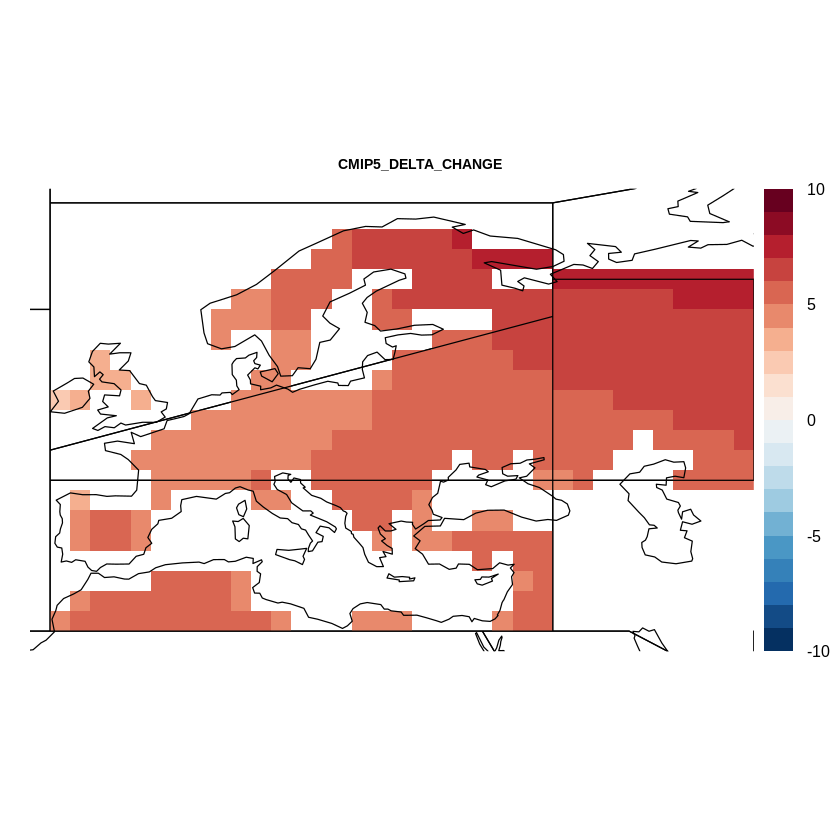

In [11]:
# Overly with reference regions
delta.masked.regs <- overGrid(delta.masked, regions[regionnames], subset = TRUE)

spatialPlot(delta.masked.regs,
            color.theme = "RdBu", 
            rev.colors = TRUE,
            strip = FALSE,
            as.table = TRUE,
            backdrop.theme = "coastline",
            sp.layout = list(list(regions, first = FALSE)),
            par.settings = list(axis.line = list(col = "transparent")),
            main =  list("CMIP5_DELTA_CHANGE",
                         cex = 0.7),
            at = seq(-10, 10, 1),
            set.max = 10,
            set.min = -10)

In [12]:
reg.averages <- sapply(regionnames, function(i){
      reg <- overGrid(delta.masked, regions[i])
      grid <- aggregateGrid(reg, aggr.spatial = list(FUN = "mean", na.rm = TRUE), weight.by.lat = TRUE)
      grid$Data
})

Calculating areal weights...



[2024-04-17 11:25:32] - Aggregating spatially...



[2024-04-17 11:25:32] - Done.



Calculating areal weights...



[2024-04-17 11:25:32] - Aggregating spatially...



[2024-04-17 11:25:32] - Done.



Calculating areal weights...



[2024-04-17 11:25:33] - Aggregating spatially...



[2024-04-17 11:25:33] - Done.



Calculating areal weights...



[2024-04-17 11:25:33] - Aggregating spatially...



[2024-04-17 11:25:33] - Done.



In [13]:
reg.averages

NEU      WCE      EEU      MED 
5.509449 5.107509 6.195886 5.063910

In [14]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS/LAPACK: /DATA/miniconda3/envs/atlas-jupyterbook/lib/libopenblasp-r0.3.25.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=es_ES.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=es_ES.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=es_ES.UTF-8          LC_NAME=es_ES.UTF-8          
 [9] LC_ADDRESS=es_ES.UTF-8        LC_TELEPHONE=es_ES.UTF-8     
[11] LC_MEASUREMENT=es_ES.UTF-8    LC_IDENTIFICATION=es_ES.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rgdal_1.5-16        sp_1.4-5            RColorBrewer_1.1-2 
 [4] visualizeR_1.6.1    geoprocessoR_0.2.0  loadeR.2nc_0.1.2   
 [7] loadeR_1.7.1        climate4R.UDG_0.2.3 loadeR.java_1.1.1  
[10] rJava_1.0-4         transformeR_2.1.3  

loaded via a namespace 